Finetune BETO on classification task

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cse493g1/project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install datasets

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch
import pandas as pd
import numpy as np

In [4]:
# use gpu
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/cse493g1/project/beto/train_country.csv')
df_val = pd.read_csv('/content/drive/MyDrive/cse493g1/project/beto/val_country.csv')
df_test = pd.read_csv('/content/drive/MyDrive/cse493g1/project/beto/test_country.csv')
countries_map = {'Filipinas': 0, 'Cuba': 1, 'España': 2, 'Portugal': 3, 'México': 4, 'Chile': 5, 'Argentina': 6, 'Venezuela': 7, 'Puerto Rico': 8, 'Costa Rica': 9, 'Colombia': 10}

In [6]:
df_train.head(5)

,Unnamed: 0,content,country-birth,rhyme,met
0,0,"Aquellas manos de la esposa ausente,\nblancas ...",2,"['A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'C', ...","['-+-+---+-+-', '+--+-+---+-', '-+---+---+-', ..."
1,1,"Este que en decoroso monumento,\nsiendo ceniza...",2,"['A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'C', ...","['+----+---+-', '+--+---+-+-', '-+--++---+-', ..."
2,2,Es un señor de medieval grandeza\nQue a todos ...,0,"['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'C', ...","['++-+---+-+-', '-+-+---+-+-', '++-+-+---+-', ..."
3,3,Símbolo de pureza que retratas\nel cándido cri...,2,"['A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'C', ...","['+----+---+-', '-+---+---+-', '+--+---+-+-', ..."
4,4,"«Victorioso laurel, Dafne esquiva,\nen cuyas v...",2,"['A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'C', ...","['--+--++--+-', '---+-+---+-', '---+---+-+-', ..."


In [20]:
# get class weights, since we have an uneven distribution of labels
train_labs = df_train['country-birth'].tolist()
class_count = np.bincount(train_labs, minlength=len(countries_map))

# normalized inverse class weight
class_weights = torch.Tensor(len(train_labs) / (len(countries_map) * class_count)).to(device)

In [21]:
print(class_weights)

tensor([ 1.6128,  0.4956,  0.1506, 10.0658,  1.8593, 10.8114,  3.6489,  5.2127,
        10.0658,  8.1086,  3.2799], device='cuda:0')


In [22]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

[646, 539, 463, 391, 283, 281, 276, 220, 220, 211, 199, 189, 184, 182, 177, 176, 142, 142, 137, 132, 132, 132, 131, 129, 129, 128, 127, 126, 126, 125, 125, 125, 125, 124, 124, 123, 122, 122, 121, 121, 120, 120, 120, 120, 120, 120, 120, 119, 119, 119, 119, 118, 118, 118, 118, 118, 118, 118, 117, 117, 117, 117, 117, 117, 117, 117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 116, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 107,

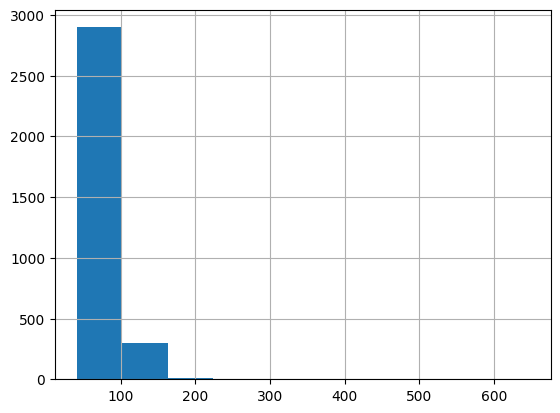

In [23]:
sequence_len = [len(c.split()) for c in df_train['content']]
sequence_len.sort(reverse=True)
pd.Series(sequence_len).hist(bins=10)
print(sequence_len)

In [24]:
# let's just set the max len to 256, nice power of 2, most of the data points are much below it
max_seq_len = 256

In [25]:
def tokenize(batch):
    return tokenizer(batch['content'], padding="max_length", truncation=True, max_length=max_seq_len)

df_train['labels'] = df_train['country-birth']
df_val['labels'] = df_val['country-birth']
df_test['labels'] = df_test['country-birth']
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)
# tokenize! both train and test
tokenized_train = train_ds.map(tokenize, batched=True)
tokenized_val = val_ds.map(tokenize, batched=True)
tokenized_test = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/3211 [00:00<?, ? examples/s]

Map:   0%|          | 0/352 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

In [13]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [26]:
from beto_classifier import BETOClassifier
import evaluate
# eval beto model
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

In [27]:
def compute_metrics(pred):
    logits, labels = pred
    # logits -> class
    predictions = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=predictions, references=labels)

    # Compute second metric (e.g., F1)
    f1_score = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    precision_score = precision_metric.compute(predictions=predictions, references=labels, average="weighted")

    recall_score = recall_metric.compute(predictions=predictions, references=labels, average="weighted")

    # Return both metrics together
    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"],
        "precision": precision_score["precision"],
        "recall": recall_score["recall"]
    }

In [28]:
model = BETOClassifier(num_classes=len(countries_map), class_weights=class_weights)
model.to(device)

# following https://huggingface.co/docs/transformers/en/training

training_args = TrainingArguments(
    output_dir="./country_out",
    per_device_train_batch_size=8,
    num_train_epochs=5,
    eval_strategy="epoch",
    report_to=[] # don't want wand ai reporting
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.081975,0.213068,0.095124,0.069290,0.213068
2,2.291600,2.126698,0.230114,0.110370,0.092541,0.230114
3,2.133200,1.961970,0.661932,0.619999,0.590836,0.661932
4,1.949700,1.814801,0.704545,0.658442,0.623535,0.704545
5,1.726700,1.787496,0.684659,0.657428,0.664693,0.684659


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=2010, training_loss=2.0235823958667356, metrics={'train_runtime': 838.5134, 'train_samples_per_second': 19.147, 'train_steps_per_second': 2.397, 'total_flos': 0.0, 'train_loss': 2.0235823958667356, 'epoch': 5.0})

In [29]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7874960899353027,
 'eval_accuracy': 0.6846590909090909,
 'eval_f1': 0.6574280111569482,
 'eval_precision': 0.6646925627311849,
 'eval_recall': 0.6846590909090909,
 'eval_runtime': 5.324,
 'eval_samples_per_second': 66.115,
 'eval_steps_per_second': 8.264,
 'epoch': 5.0}

In [30]:
pred_obj = trainer.predict(tokenized_test)
logits = pred_obj.predictions
pred_obj


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


PredictionOutput(predictions=array([[-2.7210701e+00,  1.3894235e+00,  2.3135619e+00, ...,
        -1.2736022e+00, -1.8927864e+00,  1.6123271e-03],
       [-2.6104219e+00,  1.2430234e+00,  2.5555182e+00, ...,
        -1.4003657e+00, -2.0235555e+00, -1.9354497e-01],
       [-1.9796782e+00,  1.6352086e-01,  3.0729697e+00, ...,
        -1.6067901e+00, -2.1190526e+00, -9.0167433e-01],
       ...,
       [ 4.8582128e-01,  1.5192159e+00, -1.2168529e+00, ...,
         6.0692453e-01,  1.2506207e+00,  1.1980302e-02],
       [-2.3210573e+00,  7.6875174e-01,  2.9520383e+00, ...,
        -1.5694189e+00, -2.1807208e+00, -5.9371823e-01],
       [-2.6717856e+00,  1.3245872e+00,  2.4332178e+00, ...,
        -1.3369806e+00, -1.9592915e+00, -9.1527700e-02]], dtype=float32), label_ids=array([ 1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  6,  4,  2,  6,  2,  2,
        1,  2,  2,  0,  2,  2,  2,  2,  2,  2,  2,  2,  6,  2,  4,  2,  2,
        7,  2,  0,  2,  2,  1,  2,  1,  4,  2,  2, 10,  2,  2,  2,  2,  2,

Make a plot!

In [31]:
import matplotlib.pyplot as plt

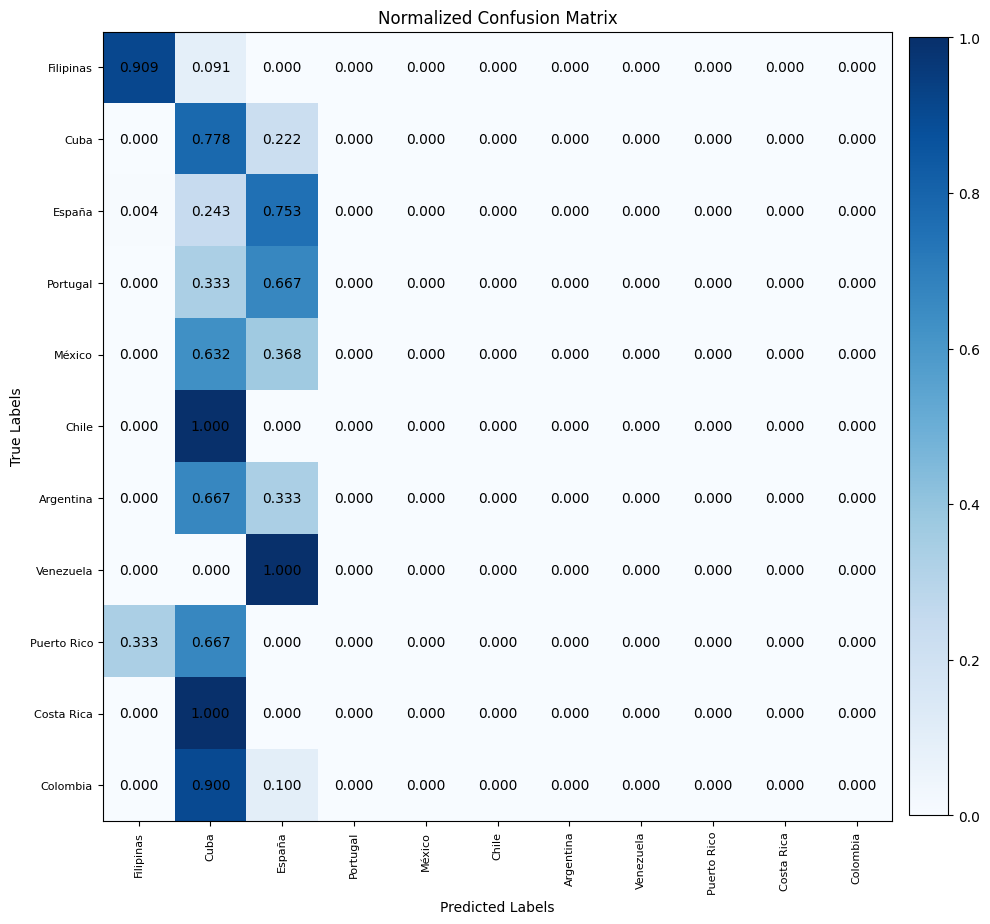

In [32]:
# visualize the splits for errors
actuals = np.argmax(logits, axis=-1)
expecteds = df_test['labels'].tolist()

# sort country ids
classes = sorted(set(expecteds))
num_classes = len(classes)

label_to_index = {label: idx for idx, label in enumerate(classes)}

mtrx = np.zeros((num_classes, num_classes), dtype=int)

for actual, predicted in zip(expecteds, actuals):
    i = label_to_index[actual]
    j = label_to_index[predicted]
    mtrx[i, j] += 1

# normalize each row (per actual class)
mtrx_normal = mtrx.astype(float) / mtrx.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(mtrx_normal, cmap='Blues', vmin=0, vmax=1)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))

# map back to labels
int_to_country = {v: k for k, v in countries_map.items()}
labels = [int_to_country[label] for label in classes]

ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticklabels(labels, fontsize=8)

# Write normalized values inside cells
for i in range(num_classes):
    for j in range(num_classes):
        value = mtrx_normal[i, j]
        if not np.isnan(value):  # avoid printing if row sum was zero
            ax.text(j, i, f'{value:.3f}', ha='center', va='center', color='black')

plt.colorbar(im, fraction=0.046, pad=0.02)
plt.tight_layout()
plt.show()

In [33]:
trainer.save_model("./country_finetuned")

Try to save model outputs

In [38]:
import shutil
from google.colab import files

shutil.make_archive('country_out', 'zip', '.', './country_out')
#shutil.make_archive('country_finetuned', 'zip', '.', './country_finetuned')
files.download('country_out.zip') # 2gb file :)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
print(actuals)

[2 2 2 1 2 2 2 2 1 2 2 1 2 2 1 2 2 1 2 2 0 2 2 1 2 2 2 1 1 2 2 1 1 2 2 2 0
 1 2 1 2 1 1 1 2 1 2 2 2 2 1 1 2 0 1 1 2 1 2 1 2 2 1 2 2 1 2 2 2 1 1 2 2 1
 2 2 2 2 0 0 1 1 2 2 2 1 1 1 2 2 1 2 1 2 2 2 2 1 2 2 2 1 1 1 2 2 2 0 2 1 2
 1 1 2 2 2 1 2 2 1 1 2 1 1 2 2 1 2 0 2 1 1 2 1 1 1 2 2 1 1 1 2 1 0 1 2 2 2
 1 1 2 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1 1 0 1 2 2 2 1 1 1 1 1
 1 1 0 2 0 1 2 1 2 1 2 1 2 1 2 2 1 2 1 1 1 2 2 1 2 1 1 2 2 1 1 2 1 2 2 1 1
 2 1 2 0 1 1 2 2 1 1 2 2 2 1 1 2 2 2 2 1 2 2 0 2 1 0 1 1 2 1 2 2 1 2 1 2 2
 2 1 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 1 1 1 1 1 1 1 0 1 0 2
 2 1 2 2 2 0 1 2 1 2 2 2 2 0 1 2 2 2 1 1 2 2 2 2 1 2 2 1 0 1 1 2 1 2 1 2 1
 2 2 1 2 2 1 2 2 2 2 1 2 1 2 2 2 1 2 1 2 2 1 2 2 2 1 2 2 1 2 2 1 2 2 0 2 2
 1 1 2 1 0 2 2 2 1 1 1 1 2 2 2 2 1 1 2 2]
